# ConvNet MNIST Pytorch
### 林峻弘 2019280374

In [0]:
import os
import torch
from torch import nn
from torch.nn import functional as fc
import pandas as pd
import numpy as np
import torchvision
from torchvision import datasets as ds
from torchvision import transforms as tf
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler as SR
%matplotlib inline
torch.cuda.set_device(0)

In [0]:
num_workers = 0
batch_size = 20
valid_size = 0.2
transform = tf.ToTensor()
train_data = ds.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = ds.MNIST(root = 'data', train = False, download = True, transform = transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                            num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

In [0]:
class CNN(nn.Module):
    def __init__(self):
      super(CNN,self).__init__()
      self.conv1 = nn.Conv2d(1,16,kernel_size = 5, stride =1, padding =0)
      self.conv2 = nn.Conv2d(16,32,kernel_size =5, stride =1, padding =0)
      self.maxpool1 = nn.MaxPool2d(2)
      self.maxpool2 = nn.MaxPool2d(2)
      self.fc = nn.Linear (32*4*4,10)
      self.relu1 = nn.ReLU()
      self.relu2 = nn.ReLU()
      self.dropout = nn.Dropout(0.3)
      self.softmax = nn.Softmax(dim =1)

    def forward(self,Input):
      out = self.conv1(Input)
      out = self.relu1(out)
      out = self.maxpool1(out)
      out = self.conv2(out)
      out = self.relu2(out)
      out = self.maxpool2(out)
      out = out.view(out.size(0),-1)
      out = self.fc(out)
      out = self.dropout(out)
      out = self.softmax(out)
      return out

In [4]:
model = CNN()
print(model)
criterion = nn.CrossEntropyLoss()
alpha = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = alpha)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=512, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (softmax): Softmax(dim=1)
)


In [5]:
epochs = 20
train_loss = []
validation_losses = []
validation_acc = []
for epoch in range(epochs):
    training_loss = 0
    accuracy =0
    model.train()
    for data,label in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        training_loss = training_loss + loss.item()
    
    model.eval()
    for data,label in valid_loader:
        output = model(data)
        loss = criterion(output,label)
        validation_loss = loss.item()
        top_p,top_class = output.topk(1,dim=1)
        same = top_class == label.view(*top_class.shape)
        accuracy += torch.mean(same.type(torch.FloatTensor))
    train_loss.append(training_loss/len(train_loader))
    validation_losses.append(validation_loss/len(valid_loader))
    validation_acc.append(accuracy/len(valid_loader))

    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(training_loss/len(train_loader)),
              "Validation Loss: {:.3f}.. ".format(validation_loss/len(valid_loader)),
          "Validation Accuracy: {:.3f}.. ".format(accuracy/len(valid_loader)))
              

Epoch: 1/20..  Training Loss: 2.124..  Validation Loss: 0.001..  Validation Accuracy: 0.815.. 
Epoch: 2/20..  Training Loss: 1.771..  Validation Loss: 0.000..  Validation Accuracy: 0.903.. 
Epoch: 3/20..  Training Loss: 1.732..  Validation Loss: 0.000..  Validation Accuracy: 0.933.. 
Epoch: 4/20..  Training Loss: 1.713..  Validation Loss: 0.000..  Validation Accuracy: 0.943.. 
Epoch: 5/20..  Training Loss: 1.703..  Validation Loss: 0.000..  Validation Accuracy: 0.948.. 
Epoch: 6/20..  Training Loss: 1.696..  Validation Loss: 0.000..  Validation Accuracy: 0.958.. 
Epoch: 7/20..  Training Loss: 1.694..  Validation Loss: 0.000..  Validation Accuracy: 0.960.. 
Epoch: 8/20..  Training Loss: 1.689..  Validation Loss: 0.000..  Validation Accuracy: 0.965.. 
Epoch: 9/20..  Training Loss: 1.687..  Validation Loss: 0.000..  Validation Accuracy: 0.966.. 
Epoch: 10/20..  Training Loss: 1.685..  Validation Loss: 0.000..  Validation Accuracy: 0.970.. 
Epoch: 11/20..  Training Loss: 1.683..  Validatio

In [6]:
testing_loss =[]
correct = 0
total = 0
with torch.no_grad():
    for data,label in test_loader:
        test_loss=0
        output = model(data)
        loss = criterion(output,label)
        test_loss = test_loss + loss.item()
        _,pred = torch.max(output,1)
        total += label.size(0)
        correct += (pred == label).sum().item()
    testing_loss.append(test_loss/len(test_loader))
    print('Accuracy: %.2f %%'%(100*correct/total))
    print("Testing Loss: {:.3f}.. ".format(test_loss/len(test_loader)))


Accuracy: 98.20 %
Testing Loss: 0.003.. 


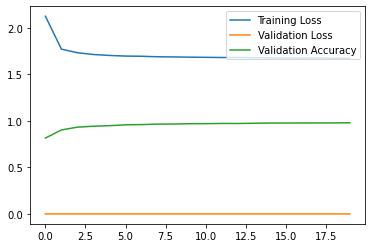

In [7]:
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.plot(validation_acc,label='Validation Accuracy')
plt.legend(frameon=True)